In [3]:
using Plots, SparseArrays, LinearAlgebra, Printf, SpecialFunctions
import Plots: plot, +, -

In [4]:
function Jacobi_ab(a,b) #TODO: simplify evaluation
    bfun = n -> (a+b==-1 && n==0) ? √(2*a*b) :
        2*sqrt(n+1)*sqrt(n+a+1)*sqrt(n+b+1)*sqrt(n+a+b+1)/
        ((2n + a +b + 2)*sqrt(2n + a +b + 3)*sqrt(2n + a +b + 1))
    afun = n -> ((a+b==0 || a+b==-1) && n==0) ? (b-a)/(a+b+2) :
        (b^2 - a^2)/((2n + a +b + 2)*(2n + a +b))
    return (n -> n < 0 ? a : afun(n),n -> n < 0 ? b : bfun(n))  # this is not needed but lets us get access
                                                                # to the Jacobi parameters after the fact
end

function Jacobi(a,b,n) # creates (n + 1) x (n+1) Jacobi matrix
   SymTridiagonal([a(i) for i in 0:n],[b(i) for i in 0:n-1])
end

function Interp_transform(a,b,n)
    E = Jacobi(a,b,n) |> eigen
    return E.values, E.vectors*(Diagonal(E.vectors[1,:]))
end

function Gauss_quad(a,b,n)
    E = Jacobi(a,b,n) |> eigen
    return E.values, abs2.(E.vectors[1,:])
end

function Interp_transform(f::Function,a,b,n)
    E = Jacobi(a,b,n) |> eigen
    E.vectors*(Diagonal(E.vectors[1,:])*map(f,E.values))
end

struct UltraFun
    a::Function
    b::Function
    c::Vector
end

function UltraFun(λ::Number,c::Vector)
    a, b = Jacobi_ab(λ - 0.5,λ - 0.5)
    UltraFun(a,b,c)
end

function UltraFun(λ::Number,f::Function,n::Integer)
    a, b = Jacobi_ab(λ - 0.5,λ - 0.5)
    UltraFun(a,b, Interp_transform(f,a,b,n))
end

struct StandardBasisVector
    j::Integer
end

function +(v::Vector,e::StandardBasisVector)
    w = copy(v)
    w[e.j] += 1
    return w
end
function +(e::StandardBasisVector,v::StandardBasisVector)
    w = copy(v)
    w[e.j] += 1
    return w
end

function -(v::Vector,e::StandardBasisVector)
    w = copy(v)
    w[e.j] -= 1
    return w
end
function -(e::StandardBasisVector,v::StandardBasisVector)
    w = copy(v)
    w[e.j] -= 1
    return w
end

function e(j)
    StandardBasisVector(j)
end

function e(j,n)
    fill(0.0,n) + e(j) 
end

function (P::UltraFun)(x) # Clenshaw's algorithm
    n = P.c |> length
    (hcat(e(1,n) |> sparse,(Jacobi(P.a,P.b,n) - x*I)[1:end-1,1:end-2] |> sparse)\P.c)[1]
end

function d(j,λ)
    j*sqrt(2*(j + 2λ)/j*(λ+1)/(2λ+1))
end

function Diff(λ,n)
    Bidiagonal(fill(0.0,n),[d(j,λ) for j=1:n-1], :U)
end

function Diff(P::UltraFun)
    α = P.a(-1)
    a, b = Jacobi_ab(α + 1.0,α + 1.0)
    UltraFun(a,b,Diff(α + 0.5,length(P.c))*P.c)
end

function poly(a,b,n,x) # a naive use of the three-term recurrence
    p = fill(0.0,n)
    p[1] = 1.0 # p_0
    p[2] = x.*p[1] - a(0)*p[1] # compute p_1
    p[2] /= b(0)
    for j = 1:n-2 # compute p_n
        p[j+2] = x.*p[j+1] - a(j)*p[j+1] - b(j-1)*p[j]
        p[j+2] /= b(j)
    end
    p
end

function poly(a,b,n,z::Vector)
    vcat(map(zz -> poly(a,b,n,zz) |> transpose , z)...)
end

function poly(λ::Number,n,z::Vector)
    a, b = Jacobi_ab(λ - 0.5,λ - 0.5)
    poly(a,b,n,z)
end

Ugrid = n -> cos.( (2*(1:n) .- 1)/(2*n) * pi )

function plot(f::UltraFun)
    x = -1:.001:1
    y = f.(x)
    p = plot()
    if norm(real(y)) > 1e-12
        plot!(x,real(y), label = "Real part")
    end
    if norm(imag(y)) > 1e-12
        plot!(x,imag(y), label = "Imaginary part")
    end
    p
end

plot (generic function with 5 methods)

Solve

$$ -\frac{d u}{dx} - x u(x) = 0, \quad u(-1) = 1.$$

In [5]:
u = x -> exp(1/2-x^2/2)

#21 (generic function with 1 method)

In [6]:
n = 30;
grid = Ugrid(n - 1);
A = -poly(1.0,n,grid)*Diff(0.0,n) - Diagonal(grid)*poly(0.0,n,grid);
B = poly(0.0,n,[-1.0]);
un = UltraFun(0.0,vcat(A,B)\e(n,n));

In [7]:
un(0.0) - u(0.0)

2.220446049250313e-16

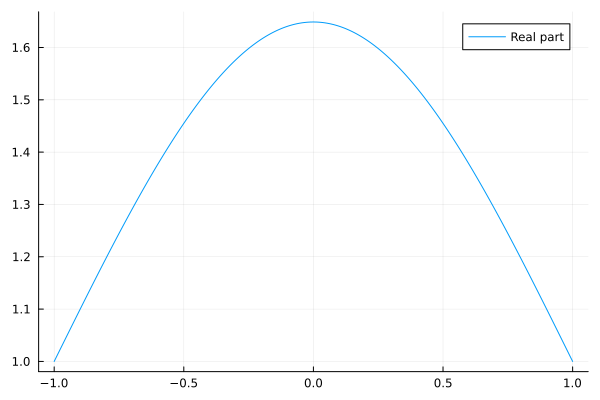

In [8]:
plot(un)

Solve

$$ -\frac{d^2 u}{dx^2} - 25 u(x) = 0, \quad u(-1) = 1, \quad u(1) = -1.$$

In [9]:
u = x -> - csc(5.0)*sin(5.0*x)

#23 (generic function with 1 method)

In [10]:
n = 40;
grid = Ugrid(n - 2);
A = -poly(2.0,n,grid)*Diff(1.0,n)*Diff(0.0,n) - 25*poly(0.0,n,grid);
B = poly(0.0,n,[-1.0,1.0]);
un = UltraFun(0.0,vcat(A,B)\(e(n-1,n) - e(n,n) ));

In [11]:
u(.3) - un(.3)

-1.3322676295501878e-15

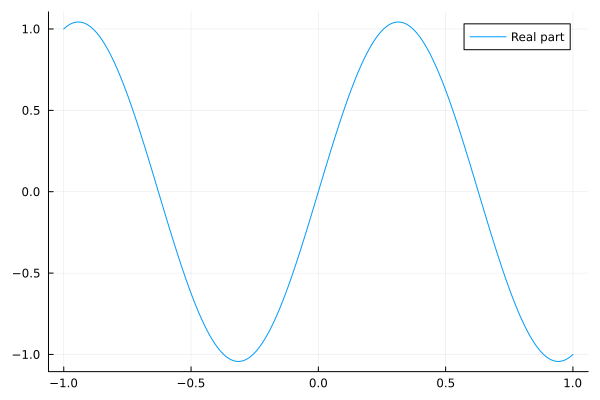

In [12]:
plot(un)

Solve

$$ -\frac{d^3 u}{dx^3} - 25xu(x) = 0, \quad u(-1) = 1, \quad u(1) = -1, \quad u'(-1) = 0.$$

In [13]:
n = 5000;
grid = Ugrid(n - 3);
A = -poly(3.0,n,grid)*(Diff(2.0,n)*Diff(1.0,n)*Diff(0.0,n)) - 25*Diagonal(grid)*poly(0.0,n,grid);
B = poly(0.0,n,[-1.0,1.0]);
C = poly(1.0,n,[-1])*Diff(0.0,n)
un = UltraFun(0.0,vcat(A,B,C)\(e(n-2,n) - e(n-1,n)));

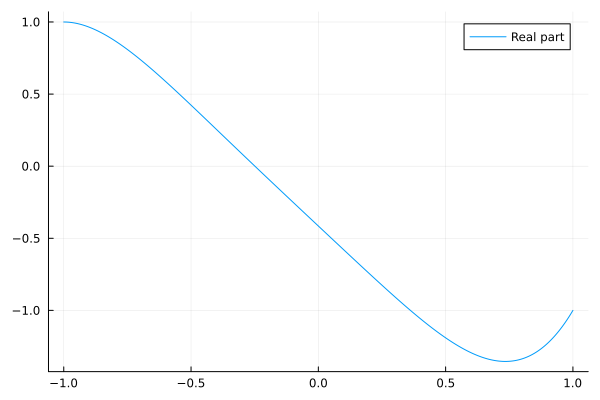

In [14]:
plot(un)

Solve

$$ \frac{d^4 u}{dx^4} - 50x^2u(x) = f(x), \quad u(-1) = 1, \quad u(1) = -1, \quad u'(-1) = 0, \quad u'(1) = 0.$$

In [15]:
n = 300;
f = x -> airybi(x*3)
grid = Ugrid(n - 4);
A = 0.0000001*poly(4.0,n,grid)*(Diff(3.0,n)*Diff(2.0,n)*Diff(1.0,n)*Diff(0.0,n)) - 20*Diagonal(grid.^2)*poly(0.0,n,grid);
B = poly(0.0,n,[-1.0,1.0]);
C = poly(1.0,n,[-1.0,1.0])*Diff(0.0,n)
a = f.(grid)
b = [1;-1]
c = [0;0]
un = UltraFun(0.0,vcat(A,B,C)\vcat(a,b,c));

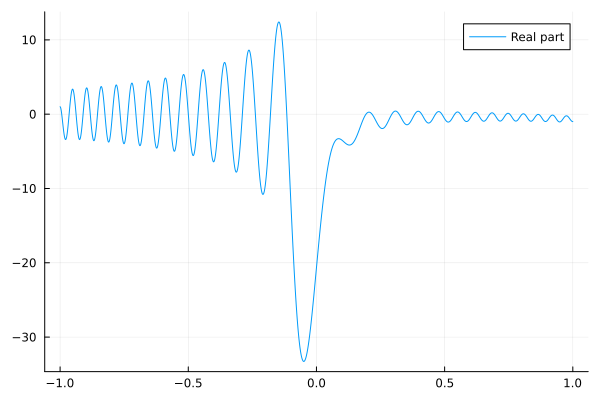

In [16]:
plot(un)